In [1]:
%matplotlib inline
import pandas as pd
from scrape.graph import get_merged_summaries_with_final_actual_intensities, create_graph_images, generate_boxplot_ci, generate_boxplot_ci_error, generate_boxplot_ci_error_for_days, generate_plot_ci_lines, generate_boxplot_ci_error_per_hour

# Carbon intensity forecast tracking

Here I'll show the basics of how this repo operates, for national data.

1. Periodically scrape JSON data from the National Grid API
2. Convert to CSV
3. Summarise in a giant combined CSV
4. Plot graphs and calculate statistics.

Most operations are possible via the CLI: see the `python3 run.py ...` commands.

## 1. Scrape JSON data from the National Grid API

We'll use the existing repo folder `./data`. Subfolders will be created for each endpoint.

The supported endpoints are defined in `api.py`. For national data, we'll use the two endpoints 

Run the following commands repeatedly every half-hour until you have gathered the data you want:
```
python run.py download --output_directory data --now --endpoint national_fw48h
python run.py download --output_directory data --now --endpoint national_pt24h
```

Gathering data as it is published, every half hour, is important because historical forecasts are overwritten/unavailable (hence this project).

## 2. Convert to CSV

```
python3 run.py wrangle --input_directory "data/national_fw48h" --endpoint "national_fw48h"
python3 run.py wrangle --input_directory "data/national_pt24h" --endpoint "national_pt24h"
```

This will create `.csv` files in the same directory with identical names as the `.json` files.

## 3. Summarise

```
python3 run.py summary --input_directory "data/national_fw48h" --output_directory "data" --endpoint "national_fw48h"
python3 run.py summary --input_directory "data/national_pt24h" --output_directory "data" --endpoint "national_pt24h"
```
This will create `summary_national_fw48h.csv` and `summary_national_pt24h.csv` files in the `data` directory which combine all the available CSVs into one file.

In [ ]:
# Example
df = pd.read_csv("./data/summary_national_fw48h.csv").head()
df

## 4. Plots and statistics

In [2]:
summaries_merged_df = get_merged_summaries_with_final_actual_intensities("data", filter="national")

In [ ]:
fig = generate_plot_ci_lines(summaries_merged_df, hours_of_data=24)

In [16]:
num_plots = 48
hours_prior = 24 + num_plots / 2
hours_prior

48.0

48


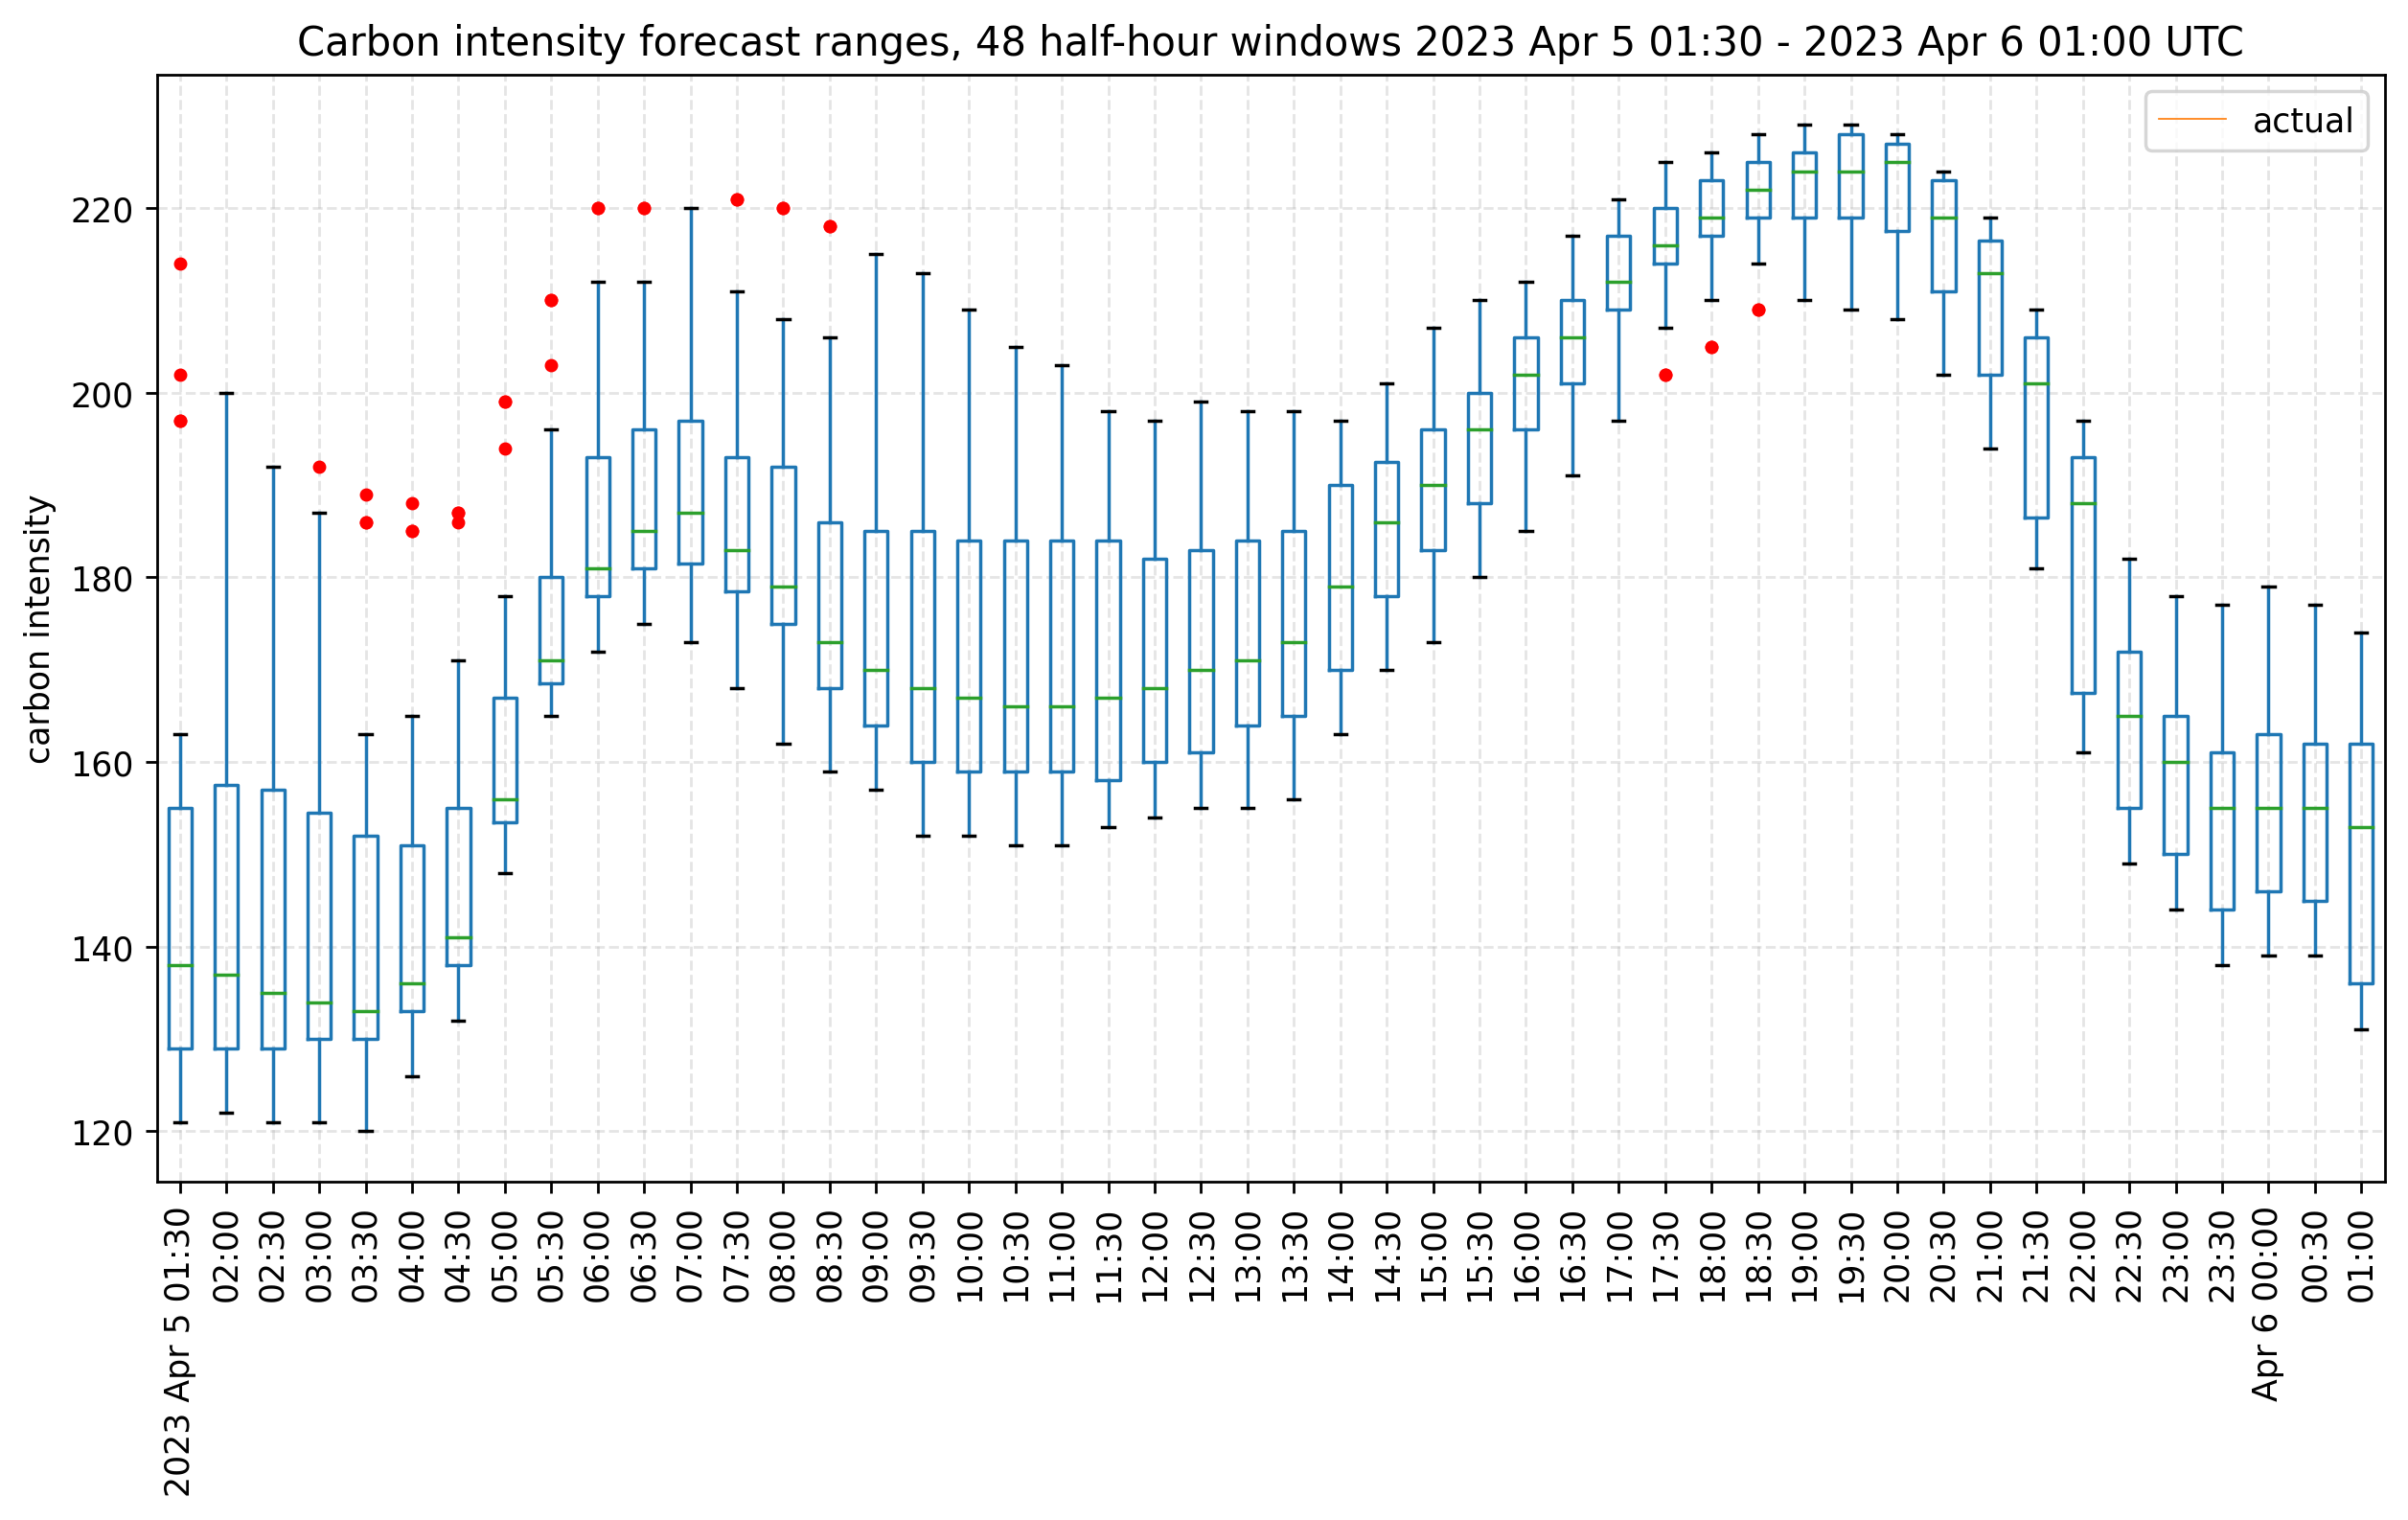

In [22]:
import importlib
import scrape.graph
importlib.reload(scrape.graph)
fig = scrape.graph.generate_boxplot_ci(summaries_merged_df, hours_of_data=24)

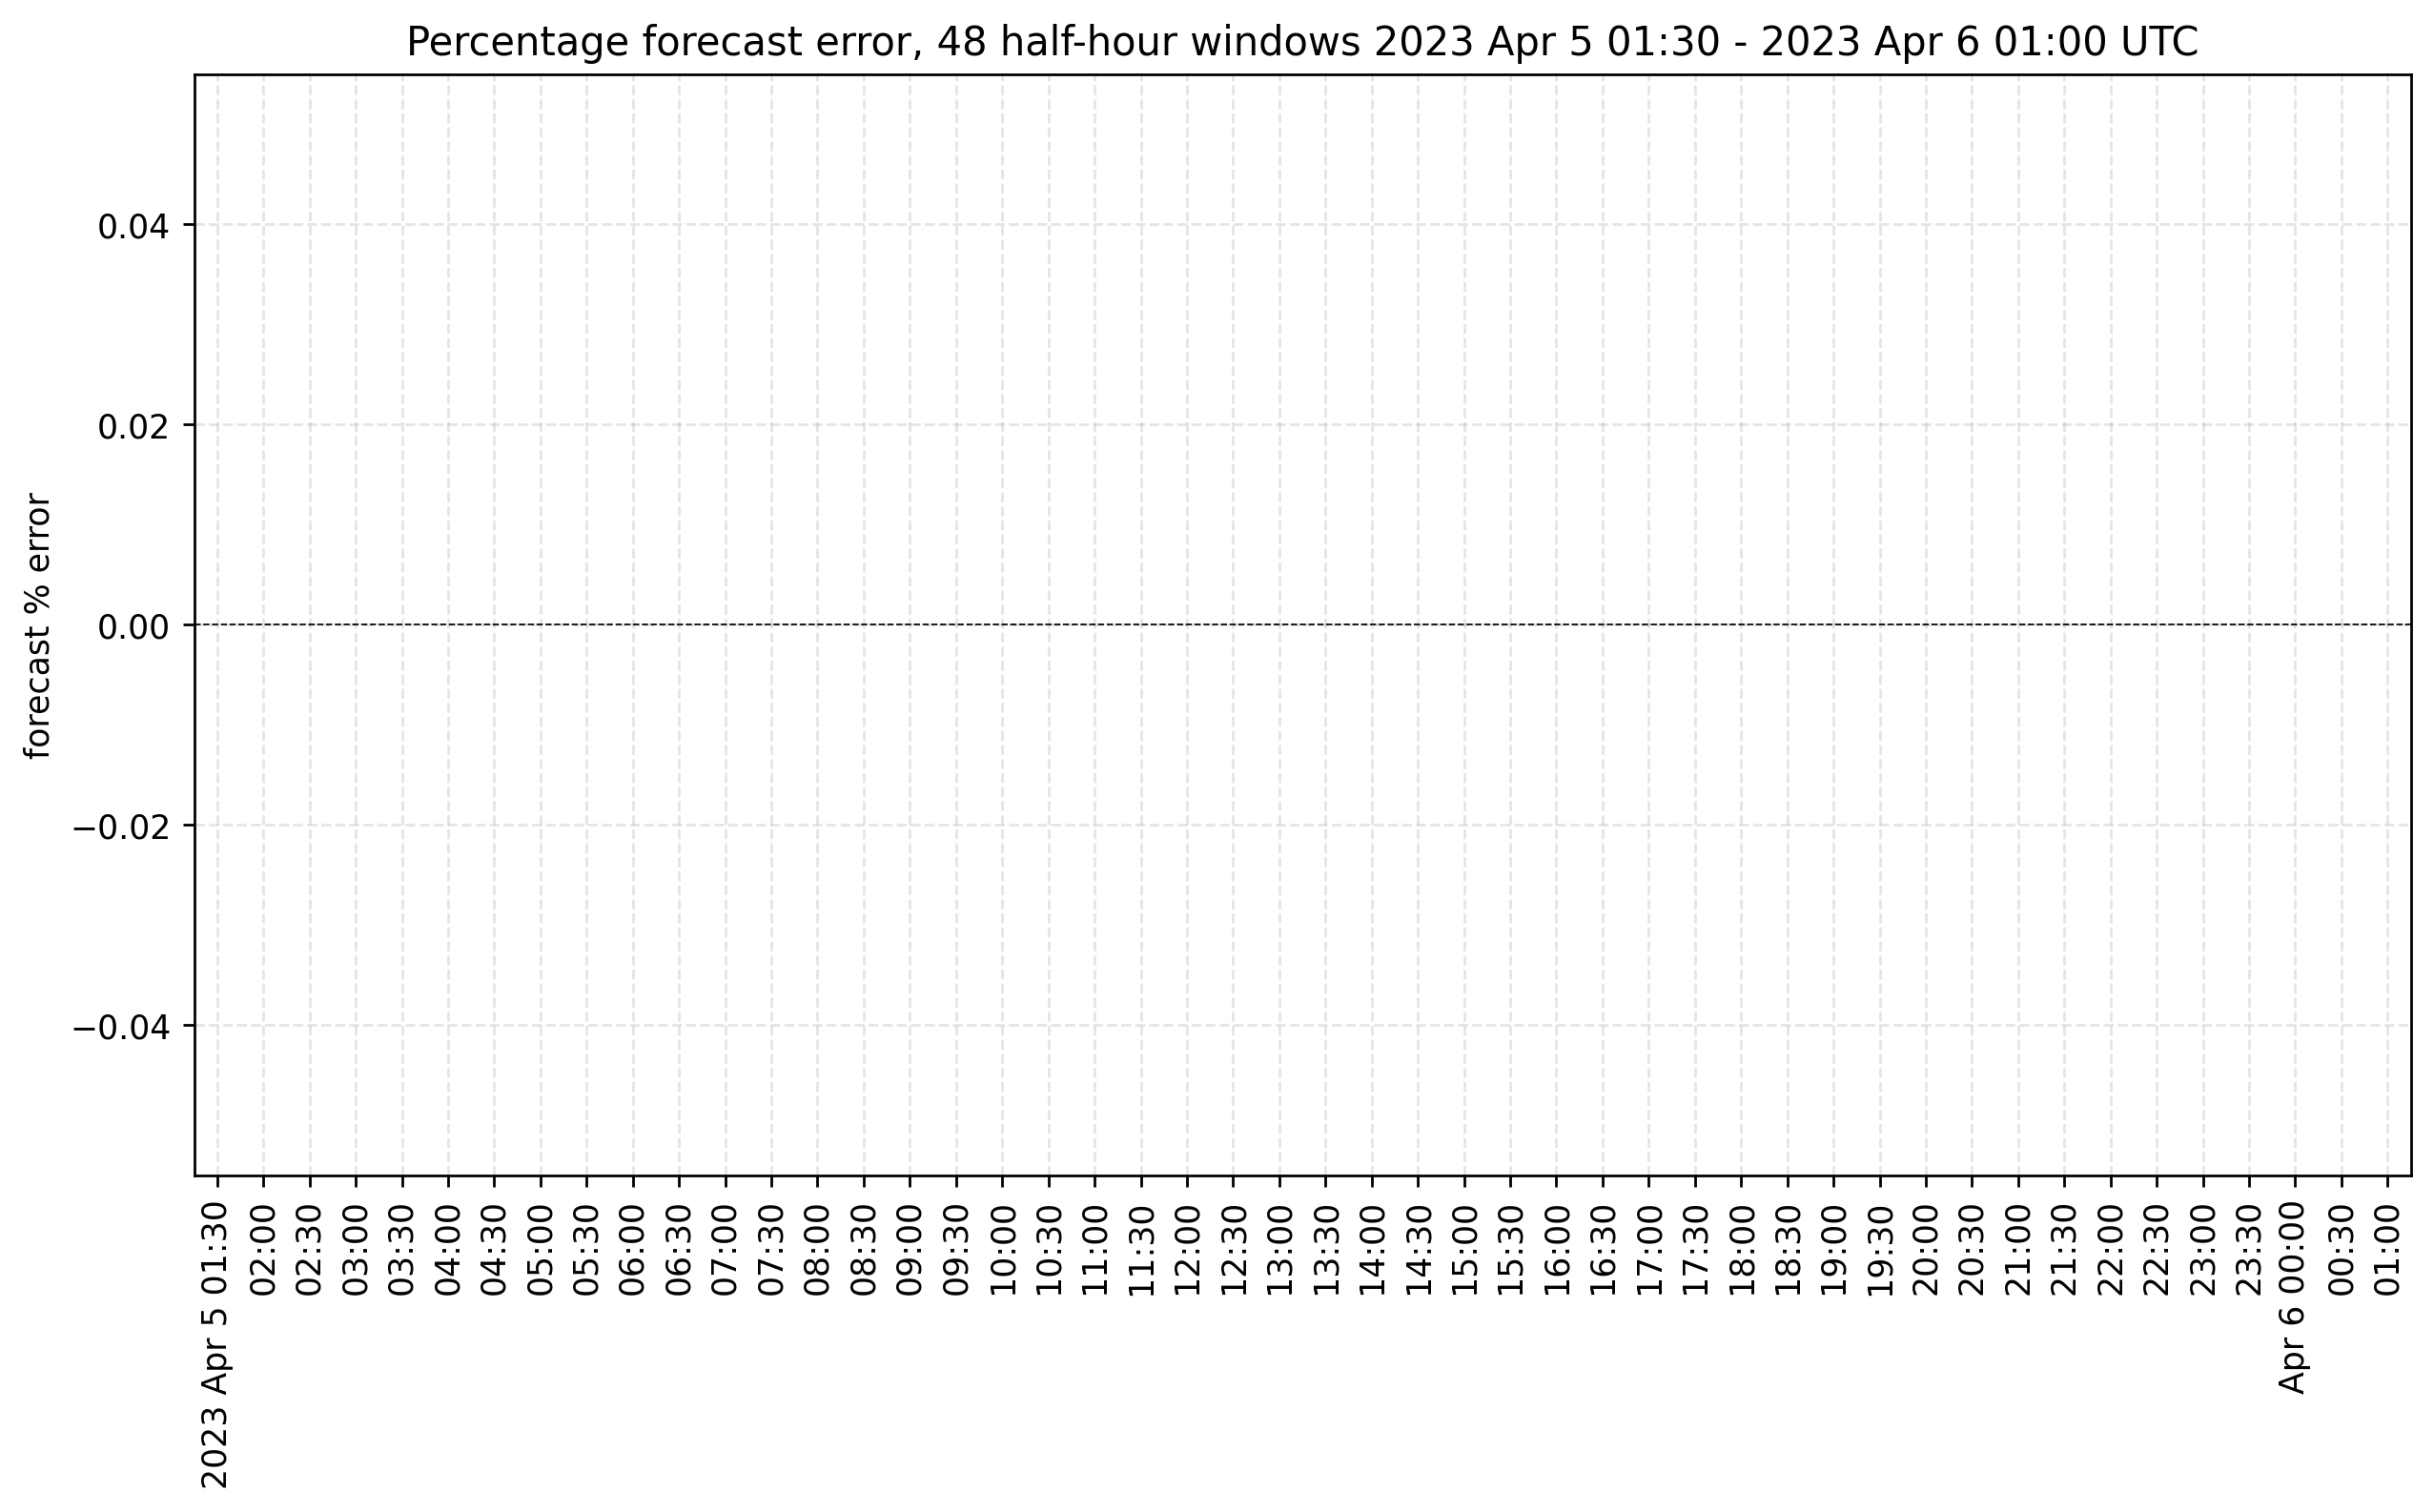

In [14]:
fig = generate_boxplot_ci_error(summaries_merged_df, 24)

In [ ]:
fig = generate_boxplot_ci_error_for_days(summaries_merged_df, 7)

In [ ]:
fig = generate_boxplot_ci_error_per_hour(summaries_merged_df, days=7)

In [ ]:
create_graph_images("data", hours_of_data=24)